# NYC Yellow Taxi Data
* Demand prediction in Jaunary, 2015
* Using public data from BigQuery

## 1. Preprocessing

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import os
from numpy.random import permutation
from sklearn import svm, datasets

from sacred import Experiment
from sacred.observers import FileStorageObserver

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='mobility-320516'

In [4]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

Downloading: 100%|██████████| 87020/87020 [00:06<00:00, 13016.79rows/s]

CPU times: user 2.53 s, sys: 241 ms, total: 2.77 s
Wall time: 27 s


- Extract data with one-hour unit from BigQuery
- Change geographic coordinate to zipcode with reverse geocoding

In [5]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10039,2015-01-01,1,1,3,0,0,9
1,11221,2015-01-01,1,1,3,0,0,34
2,10037,2015-01-01,1,1,3,0,0,26
3,10004,2015-01-01,1,1,3,0,0,139
4,11238,2015-01-01,1,1,3,0,0,95


In [6]:
def split_train_and_test(df, date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Data distribution

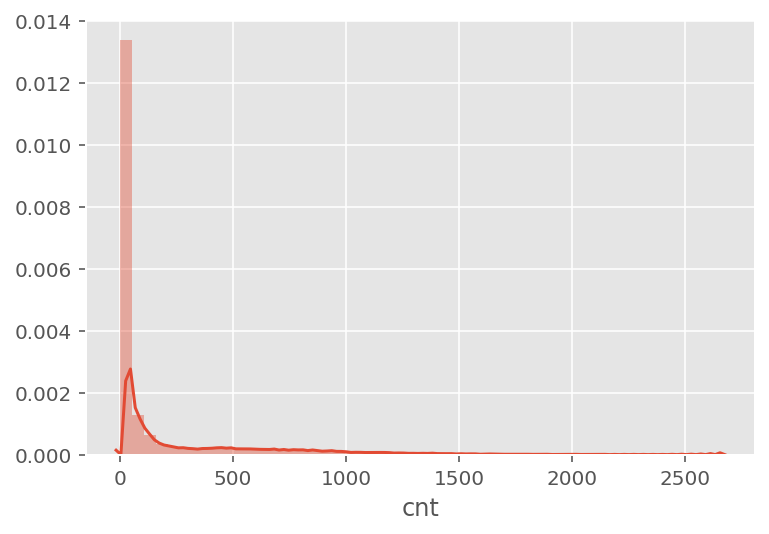

In [7]:
sns.distplot(base_df['cnt'])

- The distribution is skewed right

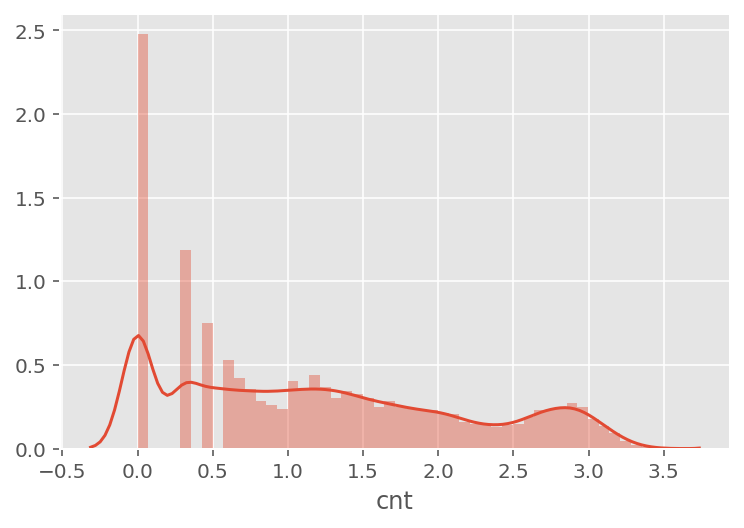

In [8]:
sns.distplot(np.log10(base_df['cnt']))

- Performed log on count

In [9]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

In [10]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10039,2015-01-01,1,1,3,0,0,9,0.954243
1,11221,2015-01-01,1,1,3,0,0,34,1.531479
2,10037,2015-01-01,1,1,3,0,0,26,1.414973
3,10004,2015-01-01,1,1,3,0,0,139,2.143015
4,11238,2015-01-01,1,1,3,0,0,95,1.977724


### Train/Test set split

In [11]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [12]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10039,2015-01-01,1,1,3,0,0,9,0.954243
1,11221,2015-01-01,1,1,3,0,0,34,1.531479
2,10037,2015-01-01,1,1,3,0,0,26,1.414973
3,10004,2015-01-01,1,1,3,0,0,139,2.143015
4,11238,2015-01-01,1,1,3,0,0,95,1.977724


In [13]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65118,10280,2015-01-24,1,24,5,0,1,26,1.414973
65119,10038,2015-01-24,1,24,5,0,1,145,2.161368
65120,10004,2015-01-24,1,24,5,0,1,88,1.944483
65121,10025,2015-01-24,1,24,5,0,1,332,2.521138
65122,11217,2015-01-24,1,24,5,0,1,91,1.959041


In [14]:
# removing unnecessary columns
del train_df['pickup_hour']
del test_df['pickup_hour']

In [15]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [16]:
x_train = train_df.copy()
x_test = test_df.copy()

In [17]:
x_train.head()

,zip_code,month,day,weekday,hour,is_weekend
0,10039,1,1,3,0,0
1,11221,1,1,3,0,0
2,10037,1,1,3,0,0
3,10004,1,1,3,0,0
4,11238,1,1,3,0,0


## 2. Simple regression
- Baseline model for comparison

In [18]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.32176716, 1.53056483, 1.55990004, ..., 0.84768815, 1.85457609,
       0.83129495])

In [19]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [20]:
evaluation(y_test_raw, 10**pred)

,mape,mae,mse
score,428.415375,126.535552,95916.687733


### Coef significance

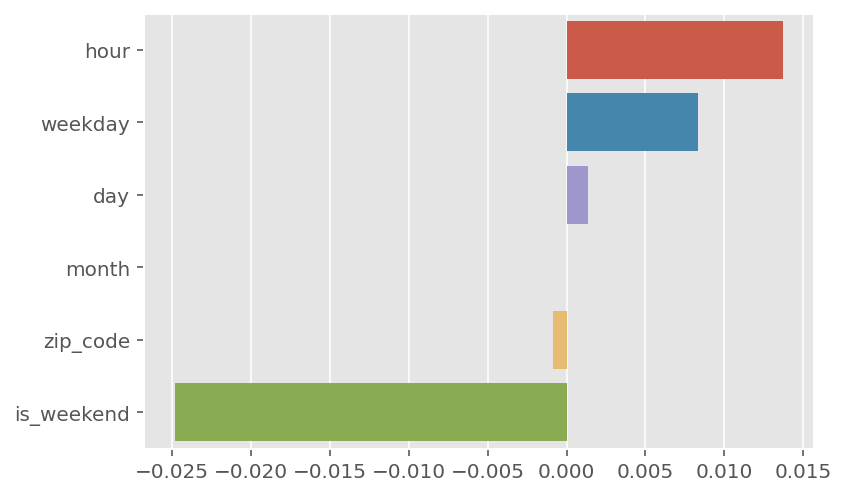

In [21]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

### save Logger

In [22]:
sl_ex = Experiment('nyc-demand-prediction_sl', interactive=True)

experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
sl_ex.observers.append(FileStorageObserver.create(experiment_dir))

In [23]:
@sl_ex.config
def config():
    fit_intercept=True
    normalize=False

In [24]:
@sl_ex.capture
def get_model(fit_intercept, normalize):
    return LinearRegression(fit_intercept, normalize)

In [25]:
@sl_ex.main
def run(_log, _run):
    lr_reg = get_model()
    lr_reg.fit(x_train, y_train_raw)
    pred = lr_reg.predict(x_test)

    _log.info("Predict End")
    score = evaluation(y_test_raw, pred)
    _run.log_scalar('model_name', lr_reg.__class__.__name__)
    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [26]:
experiment_result = sl_ex.run()

INFO - nyc-demand-prediction_sl - Running command 'run'
INFO - nyc-demand-prediction_sl - Started run with ID "6"
INFO - run - Predict End
INFO - nyc-demand-prediction_sl - Result: {'mape': {'score': 3190.201327875614}, 'mae': {'score': 185.28793226544403}, 'mse': {'score': 78953.34266541619}}
INFO - nyc-demand-prediction_sl - Completed after 0:00:00


In [27]:
experiment_result.config

{'fit_intercept': True, 'normalize': False, 'seed': 932323689}

In [28]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    output_df = output_df.round(2)
    return output_df

In [29]:
parsing_output(1)

,model_name,experiment_num,config,mae,mape,mse
score,LinearRegression,1,"{'fit_intercept': True, 'normalize': False, 's...",185.29,3190.2,78953.34


## 3. Label Encoding

In [30]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [31]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt,zip_code_le
0,10039,2015-01-01,1,1,3,0,0,9,0.954243,36
1,11221,2015-01-01,1,1,3,0,0,34,1.531479,210
2,10037,2015-01-01,1,1,3,0,0,26,1.414973,34
3,10004,2015-01-01,1,1,3,0,0,139,2.143015,3
4,11238,2015-01-01,1,1,3,0,0,95,1.977724,226


In [32]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [33]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt,zip_code_le
0,10039,2015-01-01,1,1,3,0,0,9,0.954243,36
1,11221,2015-01-01,1,1,3,0,0,34,1.531479,210
2,10037,2015-01-01,1,1,3,0,0,26,1.414973,34
3,10004,2015-01-01,1,1,3,0,0,139,2.143015,3
4,11238,2015-01-01,1,1,3,0,0,95,1.977724,226


In [34]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [35]:
del train_df['log_cnt']
del test_df['log_cnt']

In [36]:
train_df.head()

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,9,36
1,1,1,3,0,0,34,210
2,1,1,3,0,0,26,34
3,1,1,3,0,0,139,3
4,1,1,3,0,0,95,226


In [37]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [38]:
x_train = train_df.copy()
x_test = test_df.copy()

## 4. XGBoost Regressor

In [39]:
xgb_ex = Experiment('nyc-demand-prediction_xgb', interactive=True)
xgb_ex.observers.append(FileStorageObserver.create(experiment_dir))

### Save Logger

In [40]:
@xgb_ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [41]:
@xgb_ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [42]:
@xgb_ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    score = evaluation(y_test_raw, xgb_pred)
    
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)  
    _run.log_scalar('metrics', score.to_dict())

    return score.to_dict()


In [43]:
experiment_result = xgb_ex.run()

INFO - nyc-demand-prediction_xgb - Running command 'run'
INFO - nyc-demand-prediction_xgb - Started run with ID "7"
INFO - nyc-demand-prediction_xgb - Result: {'mape': {'score': 538.5201561766146}, 'mae': {'score': 57.67873599873819}, 'mse': {'score': 16512.3302373418}}
INFO - nyc-demand-prediction_xgb - Completed after 0:00:01


In [44]:
experiment_result.config

{'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 511081283}

In [45]:
parsing_output(2)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,2,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.68,538.52,16512.33


### Coef significance

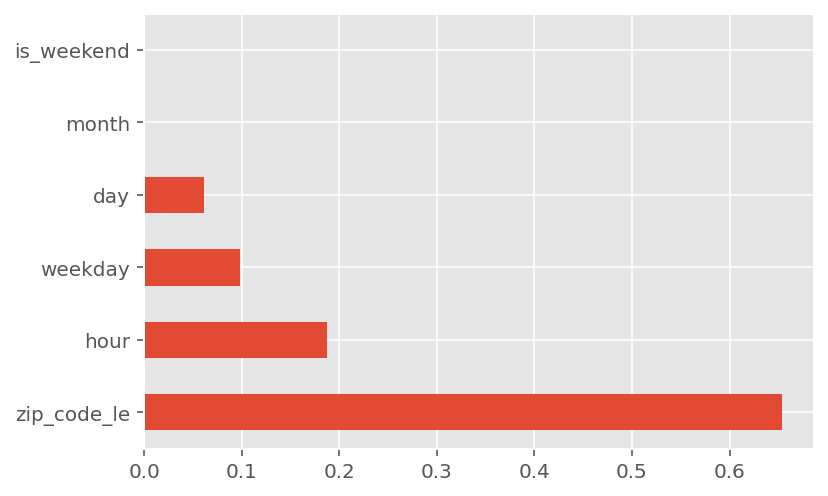

In [46]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## 5. Lightgbm Regressor

In [47]:
lgbm_ex = Experiment('nyc-demand-prediction_lgbm', interactive=True)
lgbm_ex.observers.append(FileStorageObserver.create(experiment_dir))

### Save Logger

In [48]:
@lgbm_ex.config
def config():
    num_leaves=31
    max_depth=-1
    learning_rate=0.1
    n_estimators=100

In [49]:
@lgbm_ex.capture
def get_model(num_leaves, max_depth, learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

In [50]:
@lgbm_ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)
    lgbm_pred = lgbm_reg.predict(x_test)
    score = evaluation(y_test_raw, lgbm_pred)
    
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [51]:
experiment_result = lgbm_ex.run()

INFO - nyc-demand-prediction_lgbm - Running command 'run'
INFO - nyc-demand-prediction_lgbm - Started run with ID "8"
INFO - nyc-demand-prediction_lgbm - Result: {'mape': {'score': 421.6856972338652}, 'mae': {'score': 48.24149103960721}, 'mse': {'score': 13755.684889975497}}
INFO - nyc-demand-prediction_lgbm - Completed after 0:00:00


In [52]:
experiment_result.config

{'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'seed': 685162281}

In [53]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,3,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",48.24,421.69,13755.68


### Coef significance

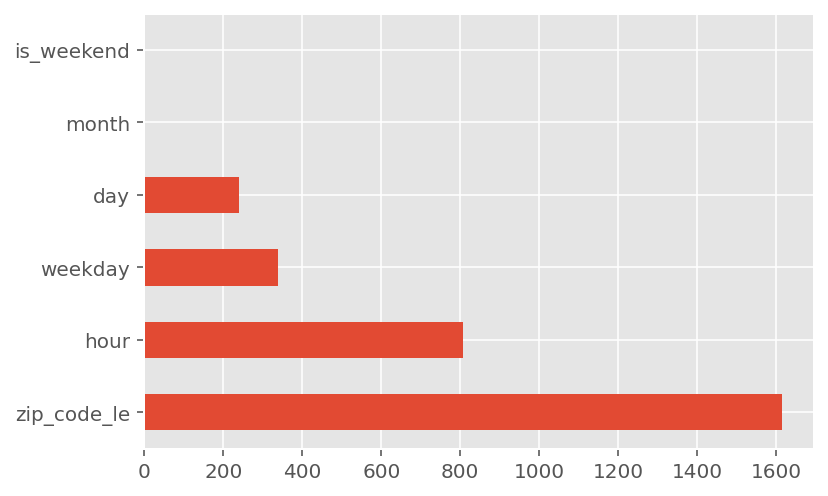

In [54]:
feat_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## 6. Random Forest Regressor

In [55]:
rf_ex = Experiment('nyc-demand-prediction_rf', interactive=True)
rf_ex.observers.append(FileStorageObserver.create(experiment_dir))

### Save Logger

In [56]:
@rf_ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [57]:
@rf_ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [58]:
@rf_ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [59]:
experiment_result = rf_ex.run()

INFO - nyc-demand-prediction_rf - Running command 'run'
INFO - nyc-demand-prediction_rf - Started run with ID "9"
INFO - nyc-demand-prediction_rf - Result: {'mape': {'score': 180.69841451730736}, 'mae': {'score': 34.75248835722765}, 'mse': {'score': 11902.818517943568}}
INFO - nyc-demand-prediction_rf - Completed after 0:00:00


In [60]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 207159803}

In [61]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,4,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 682...",35.27,184.41,12195.66


### Coef significance

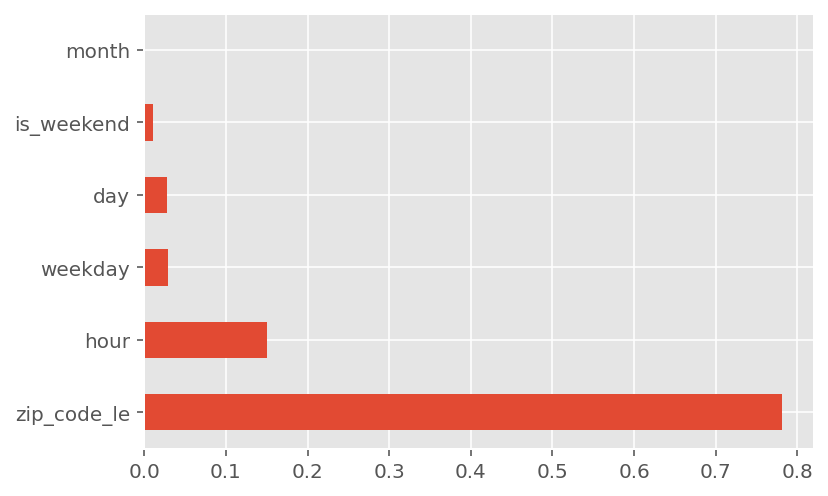

In [62]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [63]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le
65118,1,24,5,0,1,67
65119,1,24,5,0,1,35
65120,1,24,5,0,1,3
65121,1,24,5,0,1,22
65122,1,24,5,0,1,206


In [64]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

### The best model among all

In [68]:
pd.concat([parsing_output(1), parsing_output(2), parsing_output(3), parsing_output(4)])

,model_name,experiment_num,config,mae,mape,mse
score,LinearRegression,1,"{'fit_intercept': True, 'normalize': False, 's...",185.29,3190.20,78953.34
score,XGBRegressor,2,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.68,538.52,16512.33
score,LGBMRegressor,3,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",48.24,421.69,13755.68
score,RandomForestRegressor,4,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 682...",35.27,184.41,12195.66


- **Random Forest Regressor** give the lowest mae, mape, mse value

## 7. Prediction vs Actual for Random Forest Regressor (The best model)

In [69]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015

In [70]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])
del test_df['zip_code_le']

In [71]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code,y_true,y_pred,year,datetime
87015,1,31,5,23,1,10039,3,3.7,2015,2015-01-31 23:00:00
87016,1,31,5,23,1,11105,6,10.6,2015,2015-01-31 23:00:00
87017,1,31,5,23,1,11207,2,2.0,2015,2015-01-31 23:00:00
87018,1,31,5,23,1,10040,5,2.7,2015,2015-01-31 23:00:00
87019,1,31,5,23,1,11226,4,6.2,2015,2015-01-31 23:00:00


In [72]:
test_df = test_df.set_index('datetime')

In [73]:
test_df

,month,day,weekday,hour,is_weekend,zip_code,y_true,y_pred,year
datetime,,,,,,,,,
2015-01-24 00:00:00,1,24,5,0,1,10280,26,27.0,2015
2015-01-24 00:00:00,1,24,5,0,1,10038,145,126.0,2015
2015-01-24 00:00:00,1,24,5,0,1,10004,88,88.2,2015
2015-01-24 00:00:00,1,24,5,0,1,10025,332,405.2,2015
2015-01-24 00:00:00,1,24,5,0,1,11217,91,124.0,2015
...,...,...,...,...,...,...,...,...,...
2015-01-31 23:00:00,1,31,5,23,1,10039,3,3.7,2015
2015-01-31 23:00:00,1,31,5,23,1,11105,6,10.6,2015
2015-01-31 23:00:00,1,31,5,23,1,11207,2,2.0,2015


### By 'datetime'

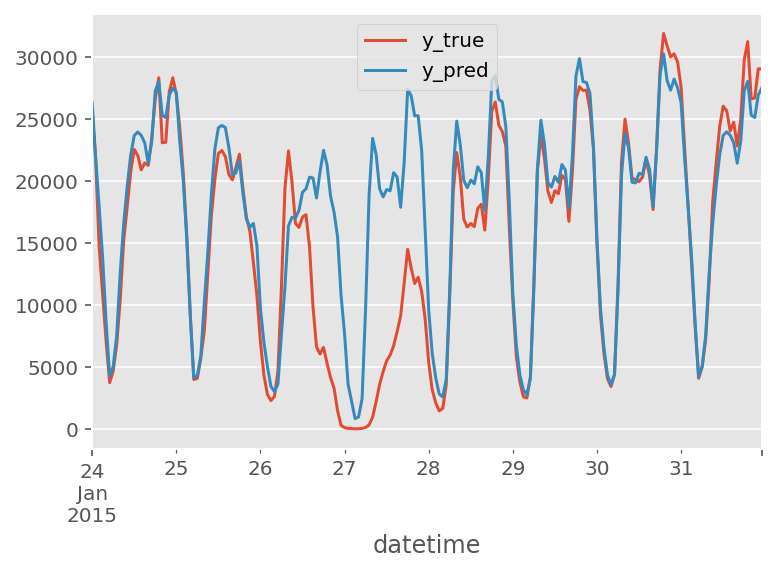

In [74]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot()

- The predictions are higher than actual values
- Failed to predict the demand when blizzard happened

### By 'hour'

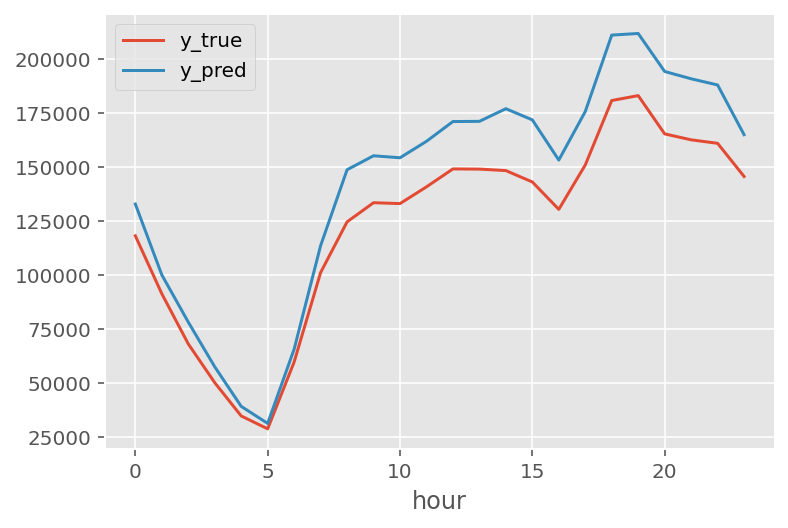

In [75]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot()

- The predictions are similar to actual values during 00:00 - 07:00
- But higher after 07:00

## 8.  Feature engineering
- add features with time

In [76]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (

  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (

  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (

  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (

  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (

  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
  LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq -   Elapsed 6.41 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 7.76 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 8.87 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 9.99 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 11.12 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 12.26 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 13.37 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 14.6 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 15.68 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 16.76 s. Waiting...
Downloading: 100%|██████████| 278256/278256 [00:33<00:00, 8331.49rows/s]
INFO - pandas_gbq.gbq - Total time taken 51.8 s.
Finished at 2021-08-19 02:15:09.


CPU times: user 10.9 s, sys: 702 ms, total: 11.6 s
Wall time: 51.8 s


- features: one-hour lag, 24-hour lag, 168-hour lag

In [77]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt
278251,14801,2015-01-31 19:00:00,1,31,5,19,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278252,14801,2015-01-31 20:00:00,1,31,5,20,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278253,14801,2015-01-31 21:00:00,1,31,5,21,1,0,0.0,1.0,0.0,0.0,0.01,0.0,0.0,0.0
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


In [78]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [79]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [80]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278059,14801,2015-01-23 19:00:00,1,23,4,19,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278060,14801,2015-01-23 20:00:00,1,23,4,20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278061,14801,2015-01-23 21:00:00,1,23,4,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278062,14801,2015-01-23 22:00:00,1,23,4,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278063,14801,2015-01-23 23:00:00,1,23,4,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373


In [81]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [82]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [83]:
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')
x_train = train_df.copy()
x_test = test_df.copy()

In [84]:
time_ex = Experiment('nyc-demand-prediction_time', interactive=True)
time_ex.observers.append(FileStorageObserver.create(experiment_dir))

### Save Logger

In [85]:
@time_ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [86]:
@time_ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [87]:
@time_ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__ + str('_time'))    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [88]:
experiment_result = time_ex.run()

INFO - nyc-demand-prediction_time - Running command 'run'
INFO - nyc-demand-prediction_time - Started run with ID "10"
INFO - nyc-demand-prediction_time - Result: {'mape': {'score': nan}, 'mae': {'score': 6.686752172459893}, 'mse': {'score': 898.7883393215241}}
INFO - nyc-demand-prediction_time - Completed after 0:00:01


In [89]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 791658605}

In [90]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor_time,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 374...",6.94,NaN,1022.13


### Coef significance

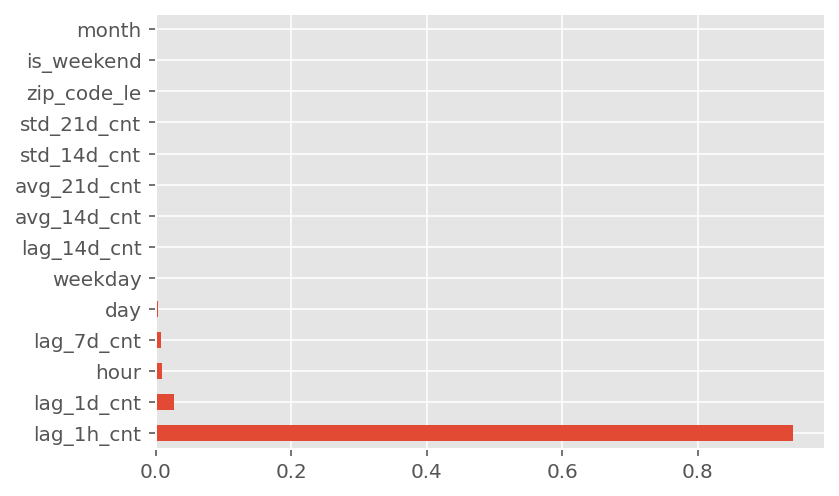

In [91]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### RF without time feature vs RF with time feature

In [98]:
pd.concat([parsing_output(4), parsing_output(5)])

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,4,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 682...",35.27,184.41,12195.66
score,RandomForestRegressor_time,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 374...",6.94,NaN,1022.13


- Compared the new RF model with the best model from last experiments
    - Our new RF model with 'time feature' gives lower mae and mse value
    - mape is 0 because true values from lag features are 0

## 9. Prediction vs Actual for RF with 'time' feature

In [92]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [93]:
test_df = test_df.set_index('datetime')

### By 'datetime'

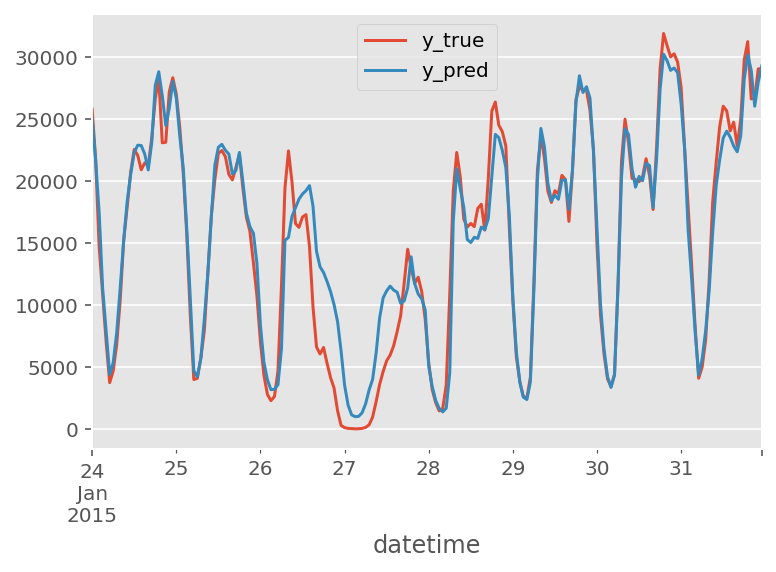

In [94]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot()

- It looks like our prediction is following the true value.
- The blizzard part is somewhat off but much better than before.

### By 'hour'

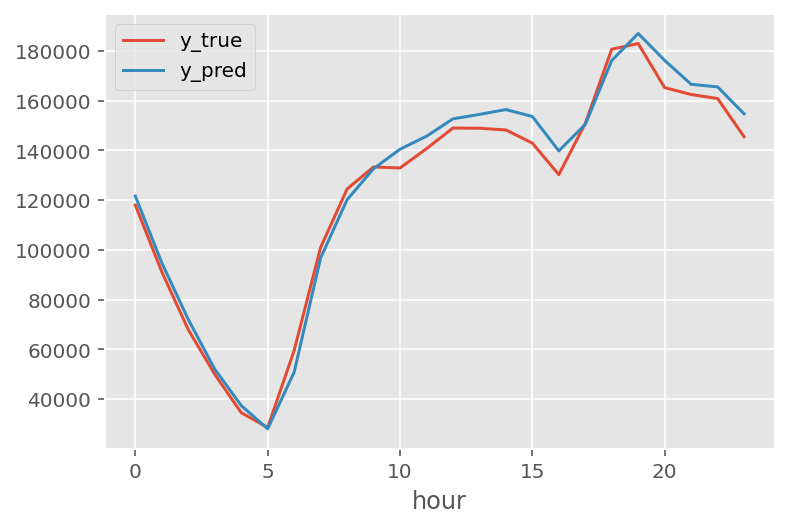

In [96]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot()

- predict much better than last model